In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
DATA_DIR = "/media/dtsarev/SatSSD/data"
TEXT_DIR = os.path.join(DATA_DIR, "text")
TRAIN_CSV = os.path.join(DATA_DIR, "train_split.csv")
VAL_CSV = os.path.join(DATA_DIR, "valid_split.csv")
EMB_DIR = "./text_embeddings_roberta"
MODEL_DIR = "./models"

TOKENIZER = "roberta-base"
MODEL = "roberta-base"

os.makedirs(EMB_DIR, exist_ok=True)

In [4]:
df_train = pd.read_csv(TRAIN_CSV, dtype={'Filename': str})
df_val = pd.read_csv(VAL_CSV, dtype={'Filename': str})
# Ensure each Filename has width 5 with leading zeros
df_train['Filename'] = df_train['Filename'].str.zfill(5)
df_val['Filename']   = df_val['Filename'].str.zfill(5)

In [5]:
def extract_and_save_embeddings(filenames, tokenizer, model, text_dir, emb_dir, max_length=128):
    """
    Extracts CLS token embeddings from a pretrained transformer model and saves them as .npy files.
    Skips empty files by saving a zero-vector embedding.
    """
    hidden_size = model.config.hidden_size
    zero_embedding = np.zeros(hidden_size, dtype=np.float32)
    model.eval()

    for fname in filenames:
        out_path = os.path.join(emb_dir, f"{fname}.npy")
        if os.path.exists(out_path):
            continue  # skip if embedding already exists

        file_path = os.path.join(text_dir, f"{fname}.txt")
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read().strip()
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Using zero embedding.")
            np.save(out_path, zero_embedding)
            continue

        if len(text) == 0:
            # Handle empty file
            np.save(out_path, zero_embedding)
            continue

        # Tokenize and prepare input tensors
        inputs = tokenizer(text, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Forward pass to get hidden states
        with torch.no_grad():
            outputs = model(**inputs)
            # Use the [CLS] token embedding (position 0)
            cls_emb = outputs.last_hidden_state[:, 0, :].squeeze(0).cpu().numpy()

        np.save(out_path, cls_emb)
    print("Embedding extraction complete.")

In [20]:
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)
model = AutoModel.from_pretrained(MODEL).to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
train_files = df_train['Filename'].astype(str).tolist()
val_files = df_val['Filename'].astype(str).tolist()
extract_and_save_embeddings(train_files, tokenizer, model, TEXT_DIR, EMB_DIR)
extract_and_save_embeddings(val_files, tokenizer, model, TEXT_DIR, EMB_DIR)

Embedding extraction complete.
Embedding extraction complete.


In [21]:
class EmbeddingDataset(Dataset):
    def __init__(self, df, emb_dir):
        self.df = df.reset_index(drop=True)
        self.emb_dir = emb_dir
        self.targets = df[['Admiration', 'Amusement', 'Determination', 'Empathic Pain', 'Excitement', 'Joy']].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['Filename']
        emb_path = os.path.join(self.emb_dir, f"{fname}.npy")
        emb = np.load(emb_path)
        emb_tensor = torch.from_numpy(emb)
        target = torch.from_numpy(self.targets[idx])
        return emb_tensor, target

In [22]:
batch_size = 32
train_dataset = EmbeddingDataset(df_train, EMB_DIR)
val_dataset   = EmbeddingDataset(df_val,   EMB_DIR)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader    = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

In [23]:
class EmotionRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super(EmotionRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim//2, 6)  # 6 emotion outputs
        )

    def forward(self, x):
        return self.model(x)

In [24]:
# Instantiate model, loss, optimizer
input_size = model.config.hidden_size
regressor = EmotionRegressor(input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [25]:
# Pearson correlation metric
def pearson_corr(preds, targets):
    preds = preds.detach().cpu()
    targets = targets.detach().cpu()
    vx = preds - preds.mean(0)
    vy = targets - targets.mean(0)
    corr = (vx * vy).sum(0) / (torch.sqrt((vx**2).sum(0) * (vy**2).sum(0)) + 1e-8)
    return corr.mean().item()

In [26]:
def train_eval(model, train_loader, val_loader, epochs=50, patience=5):
    history = {'train_loss': [], 'val_loss': [], 'train_corr': [], 'val_corr': []}
    best_loss = float('inf')
    no_improve = 0
    best_model_path = os.path.join(MODEL_DIR, 'best_model.pt')

    for epoch in range(1, epochs+1):
        # Training phase
        model.train()
        running_loss, running_corr = 0.0, 0.0
        for embeddings, targets in train_loader:
            embeddings, targets = embeddings.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * embeddings.size(0)
            running_corr += pearson_corr(outputs, targets) * embeddings.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_corr = running_corr / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_corr = 0.0, 0.0
        with torch.no_grad():
            for embeddings, targets in val_loader:
                embeddings, targets = embeddings.to(device), targets.to(device)
                outputs = model(embeddings)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * embeddings.size(0)
                val_corr += pearson_corr(outputs, targets) * embeddings.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_corr = val_corr / len(val_loader.dataset)

        # Scheduler step on validation loss
        scheduler.step(epoch_val_loss)

        # Early stopping and model saving
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            no_improve = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"--> New best model saved at epoch {epoch}")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Stopping early at epoch {epoch} after {patience} epochs with no improvement.")
                break

        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_corr'].append(epoch_train_corr)
        history['val_corr'].append(epoch_val_corr)

        # Logging per epoch
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}/{epochs}"
              f" | Train Loss: {epoch_train_loss:.4f}, Train Corr: {epoch_train_corr:.4f}"
              f" | Val Loss: {epoch_val_loss:.4f}, Val Corr: {epoch_val_corr:.4f}"
              f" | LR: {current_lr:.2e}")

    return history

In [27]:
# Run training
num_epochs = 100
history = train_eval(regressor, train_loader, val_loader, epochs=num_epochs, patience=5)

--> New best model saved at epoch 1
Epoch 1/100 | Train Loss: 0.0451, Train Corr: 0.0070 | Val Loss: 0.0379, Val Corr: 0.0991 | LR: 1.00e-04
--> New best model saved at epoch 2
Epoch 2/100 | Train Loss: 0.0429, Train Corr: 0.0275 | Val Loss: 0.0374, Val Corr: 0.1564 | LR: 1.00e-04
--> New best model saved at epoch 3
Epoch 3/100 | Train Loss: 0.0421, Train Corr: 0.0582 | Val Loss: 0.0369, Val Corr: 0.2133 | LR: 1.00e-04
--> New best model saved at epoch 4
Epoch 4/100 | Train Loss: 0.0412, Train Corr: 0.1172 | Val Loss: 0.0363, Val Corr: 0.2413 | LR: 1.00e-04
--> New best model saved at epoch 5
Epoch 5/100 | Train Loss: 0.0402, Train Corr: 0.1722 | Val Loss: 0.0355, Val Corr: 0.2601 | LR: 1.00e-04
--> New best model saved at epoch 6
Epoch 6/100 | Train Loss: 0.0394, Train Corr: 0.2162 | Val Loss: 0.0351, Val Corr: 0.2704 | LR: 1.00e-04
--> New best model saved at epoch 7
Epoch 7/100 | Train Loss: 0.0386, Train Corr: 0.2466 | Val Loss: 0.0350, Val Corr: 0.2827 | LR: 1.00e-04
--> New best 

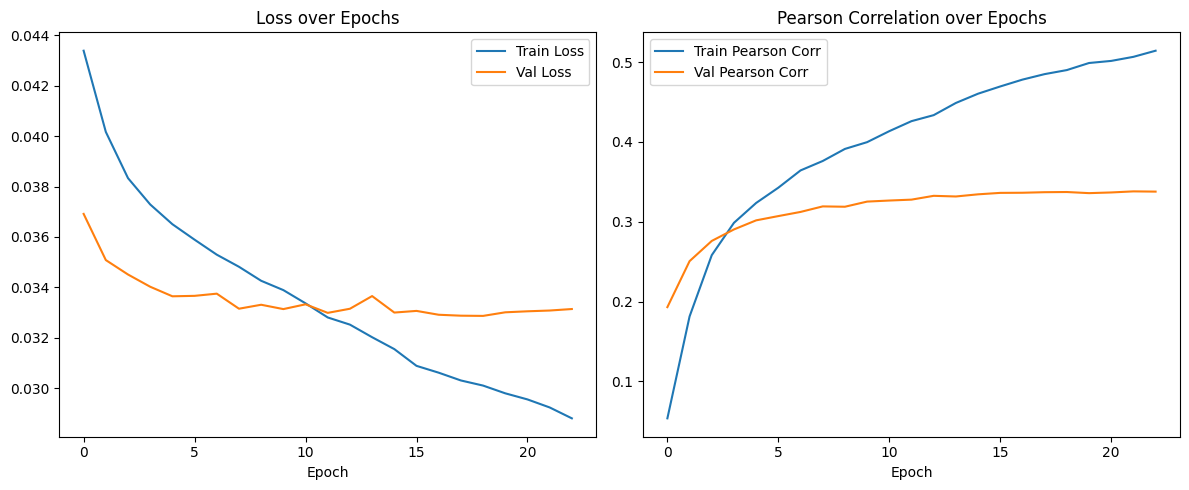

In [15]:
# Plotting training curves
plt.figure(figsize=(12, 5))
# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.legend()

# Pearson correlation curve
plt.subplot(1, 2, 2)
plt.plot(history['train_corr'], label='Train Pearson Corr')
plt.plot(history['val_corr'], label='Val Pearson Corr')
plt.title('Pearson Correlation over Epochs')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
from scipy.stats import pearsonr

# Load best model weights
best_model_path = os.path.join(MODEL_DIR, 'best_model_mpnet.pt')
regressor.load_state_dict(torch.load(best_model_path))
regressor.eval()

# Gather all predictions and targets
all_preds = []
all_targets = []
with torch.no_grad():
    for embeddings, targets in val_loader:
        embeddings = embeddings.to(device)
        outputs = regressor(embeddings).cpu().numpy()
        all_preds.append(outputs)
        all_targets.append(targets.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Emotion names
emotion_names = ['Admiration', 'Amusement', 'Determination', 'Empathic Pain', 'Excitement', 'Joy']

# Compute Pearson correlation for each emotion
dim_corrs = {}
for i, name in enumerate(emotion_names):
    corr_coef, _ = pearsonr(all_preds[:, i], all_targets[:, i])
    dim_corrs[name] = corr_coef
    print(f"{name}: Pearson correlation = {corr_coef:.4f}")

# Identify emotion with highest correlation
best_emotion = max(dim_corrs, key=dim_corrs.get)
best_value = dim_corrs[best_emotion]
print(f"Emotion with highest validation correlation: {best_emotion} ({best_value:.4f})")

Admiration: Pearson correlation = 0.4732
Amusement: Pearson correlation = 0.3510
Determination: Pearson correlation = 0.3656
Empathic Pain: Pearson correlation = 0.3886
Excitement: Pearson correlation = 0.3360
Joy: Pearson correlation = 0.3089
Emotion with highest validation correlation: Admiration (0.4732)
